# 10 minutes to Pingouin

## 1. T-test

In [1]:
import numpy as np
import pandas as pd
import pingouin as pg

# Set the default Pandas float precision to 3 decimals
pd.set_option("display.precision", 3)

np.random.seed(123)
mean, cov, n = [4, 5], [(1, .6), (.6, 1)], 30
x, y = np.random.multivariate_normal(mean, cov, n).T

# T-test
pg.ttest(x, y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.401,58,two-sided,0.001,"[-1.68, -0.43]",0.878,26.155,0.917


## 2. Pearson's correlation

In [2]:
pg.corr(x, y)

,n,r,CI95%,p-val,BF10,power
pearson,30,0.595,"[0.3, 0.79]",5.274e-04,69.723,0.95


## 3. Robust correlation

In [3]:
# Introduce an outlier
x[5] = 18
# Use the robust biweight midcorrelation
pg.corr(x, y, method="bicor")

,n,r,CI95%,p-val,power
bicor,30,0.576,"[0.27, 0.78]",8.694e-04,0.933


## 4. Test the normality of the data

In [4]:
display(pg.normality(x))                                    # Univariate normality
pg.multivariate_normality(np.column_stack((x, y)))          # Multivariate normality

,W,pval,normal
0,0.615,1.129e-07,False


HZResults(hz=1.6967733646126617, pval=0.00018201726664169923, normal=False)

## 5. One-way ANOVA using a pandas DataFrame

In [5]:
# Read an example dataset
df = pg.read_dataset('mixed_anova')

# Run the ANOVA
aov = pg.anova(data=df, dv='Scores', between='Group', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Group,5.460,1,5.460,5.244,0.023,0.029
1,Within,185.343,178,1.041,NaN,NaN,NaN


## 6. Repeated measures ANOVA

In [6]:
pg.rm_anova(data=df, dv='Scores', within='Time', subject='Subject', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,Time,7.628,2,3.814,3.913,0.023,0.062,0.999
1,Error,115.027,118,0.975,NaN,NaN,NaN,NaN


## 7. Post-hoc tests corrected for multiple-comparisons

In [7]:
# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=df, dv='Scores', within='Time', subject='Subject', 
                             parametric=True, padjust='fdr_bh', effsize='hedges')

posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Time,August,January,True,True,-1.740,59.0,two-sided,0.087,0.131,fdr_bh,0.582,-0.328
1,Time,August,June,True,True,-2.743,59.0,two-sided,0.008,0.024,fdr_bh,4.232,-0.483
2,Time,January,June,True,True,-1.024,59.0,two-sided,0.310,0.310,fdr_bh,0.232,-0.170


**Non-parametric version (= pairwise wilcoxon tests)**

In [8]:
# FDR-corrected post hocs with Hedges'g effect size
pg.pairwise_ttests(data=df, dv='Scores', within='Time', subject='Subject', 
                   parametric=False, padjust='fdr_bh', effsize='hedges')

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Time,August,January,True,False,716.0,two-sided,0.144,0.216,fdr_bh,-0.328
1,Time,August,June,True,False,564.0,two-sided,0.010,0.030,fdr_bh,-0.483
2,Time,January,June,True,False,887.0,two-sided,0.840,0.840,fdr_bh,-0.170


## 8. Two-way mixed ANOVA

In [9]:
aov = pg.mixed_anova(data=df, dv='Scores', between='Group', within='Time',
                       subject='Subject', correction=False)
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,5.460,1,58,5.460,5.052,0.028,0.080,NaN
1,Time,7.628,2,116,3.814,4.027,0.020,0.065,0.999
2,Interaction,5.167,2,116,2.584,2.728,0.070,0.045,NaN


## 9. Pairwise correlations between columns of a dataframe

See [04_Correlations.ipynb](04_Correlations.ipynb) for more examples.

In [10]:
np.random.seed(123)
z = np.random.normal(5, 1, 30)
data = pd.DataFrame({'X': x, 'Y': y, 'Z': z})

# Pairwise correlations
pg.pairwise_corr(data, columns=['X', 'Y', 'Z'], method='pearson')

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,X,Y,pearson,two-sided,30,0.366,"[0.01, 0.64]",0.047,1.5,0.525
1,X,Z,pearson,two-sided,30,0.251,"[-0.12, 0.56]",0.181,0.534,0.272
2,Y,Z,pearson,two-sided,30,0.020,"[-0.34, 0.38]",0.916,0.228,0.051


**Alternative, as a correlation matrix with p-values**

In [11]:
data[['X', 'Y', 'Z']].rcorr(method='spearman')

,X,Y,Z
X,-,***,
Y,0.573,-,
Z,0.168,0.021,-


## 10. Convert between effect sizes

In [12]:
# Convert from Cohen's d to Hedges' g
pg.convert_effsize(0.4, 'cohen', 'hedges', nx=10, ny=12)

0.38481012658227853

## 11. Multiple linear regression

In [13]:
pg.linear_regression(data[['X', 'Z']], data['Y'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.650,0.841,5.530,7.362e-06,0.139,0.076,2.925,6.376
1,X,0.143,0.068,2.089,4.630e-02,0.139,0.076,0.003,0.283
2,Z,-0.069,0.167,-0.416,6.809e-01,0.139,0.076,-0.412,0.273


## 12. Mediation analysis

In [14]:
pg.mediation_analysis(data=data, x='X', m='Z', y='Y', seed=42, n_boot=1000)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Z ~ X,0.103,0.075,0.181,-0.051,0.256,No
1,Y ~ Z,0.018,0.171,0.916,-0.332,0.369,No
2,Total,0.136,0.065,0.047,0.002,0.269,Yes
3,Direct,0.143,0.068,0.046,0.003,0.283,Yes
4,Indirect,-0.007,0.025,0.898,-0.069,0.029,No


## 13. Plot achieved power of a paired T-test

Plot the curve of achieved power given the effect size (Cohen d) and the sample size of a paired T-test.

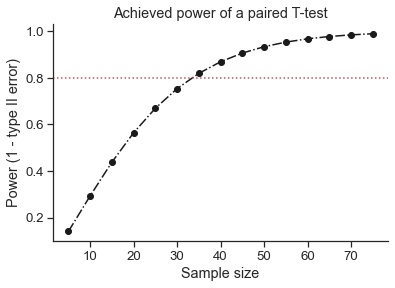

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

d = 0.5  # Fixed effect size
n = np.arange(5, 80, 5)  # Incrementing sample size

# Compute the achieved power
pwr = pg.power_ttest(d=d, n=n, contrast='paired')

# Start the plot
plt.plot(n, pwr, 'ko-.')
plt.axhline(0.8, color='r', ls=':')
plt.xlabel('Sample size')
plt.ylabel('Power (1 - type II error)')
plt.title('Achieved power of a paired T-test')
sns.despine()

## 14. Paired plot

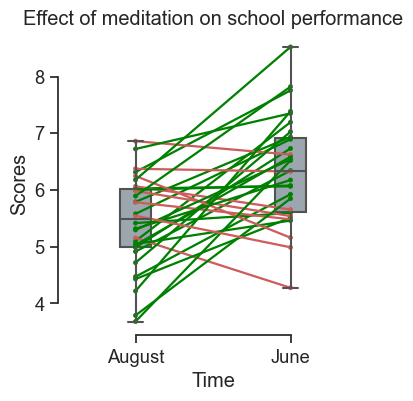

In [16]:
df = pg.read_dataset('mixed_anova').query("Group == 'Meditation' and Time != 'January'")
ax = pg.plot_paired(data=df, dv='Scores', within='Time', subject='Subject')
_ = ax.set_title("Effect of meditation on school performance")

## 15. Chi-squared test of independence

In [17]:
data = pg.read_dataset('chi2_independence')
expected, observed, stats = pg.chi2_independence(data, x='sex', y='target')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,22.717,1.0,1.877e-06,0.274,0.997
1,cressie-read,0.667,22.931,1.0,1.679e-06,0.275,0.998
2,log-likelihood,0.000,23.557,1.0,1.212e-06,0.279,0.998
3,freeman-tukey,-0.500,24.220,1.0,8.595e-07,0.283,0.998
4,mod-log-likelihood,-1.000,25.071,1.0,5.526e-07,0.288,0.999
5,neyman,-2.000,27.458,1.0,1.605e-07,0.301,0.999
